# **TheoTF Example Notebook**.

This notebook outlines how to use TheoTF for evolutionary hyperparameter optimization of TensorFlow Sequential models.

## **Preliminary Setup**

We start by importing all necessary modules. All we need here is `keras` and the `ptypes` and `optimizers` modules from TheoTF. We also import `matplotlib` to plot optimization results and `time` to measure how much time the optimization procedure takes to complete.

In [1]:
from theotf import ptypes, optimizers
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from time import time

2022-08-05 13:38:26.538180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 13:38:26.538245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TheoTF requires the user to specify the **architecture** of the model whose hyperparameters must be optimized. This operation consists in simply defining a keras Sequential model with all its layers.

Here we define a very simple full-connected model with dropout to classify the mnist dataset. It is strongly advised to give explicit names to all layers (or at least those with hyperparameters to optimize) so that they can be easily referenced later on to tell TheoTF which hyperparameters it must optimize.

In [2]:
refModel = keras.Sequential([keras.layers.Flatten(),
                             keras.layers.Dense(units=32, activation='relu', name='Dense1'),
                             keras.layers.Dropout(rate=0.3, name='Dropout1'),
                             keras.layers.Dense(units=32, activation='relu', name='Dense2'),
                             keras.layers.Dropout(rate=0.3, name='Dropout2'),
                             keras.layers.Dense(units=10, name='Dense3')])

2022-08-05 13:38:28.982673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-05 13:38:28.982709: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-05 13:38:28.982741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-08-05 13:38:28.983183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As a next step we are going to prepare data we'll use to optimize our models.

In [3]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_val, y_val = x_train[48000:], y_train[48000:]
x_train, y_train = x_train[:48000], y_train[:48000]

earlyStoppingCBK = keras.callbacks.EarlyStopping(patience=3, mode='min', restore_best_weights=True)

Here we will define the main structure used to tell TheoTF which hyperparameters must be optimized. Documentation refers to this structure as a **parameters grid**, and essentially is a Python dictonary. Let's suppose we want to optimize the number of neurons in the first dense layer of our model, which we named 'Dense1'. Each Keras `Layer` object has several attributes, those we can set when we define a model. In our case, the number of neurons is given by the `units` attribute. Let's say that we want to search for an optimal value of the number of neurons within the range [32, 128]. We can specify all that by adding the following key:value pair in the parameters grid:

``` python
'Dense1.units': ptypes.DRange(32, 128)
```
The key here is called a *parameter string*: a string formatted as `layerName.attributeName`, telling TheoTF to otimize the attribute called `attributeName` from the layer called `layerName`. The value is specified as a `ptypes.DRange` object, from the `theotf.ptypes` module. *DRange* stands for discrete range and tells TheoTF that the corresponding parameter can assume all possible integer values between 32 and 128 (both included). Apart from the `DRange` class, the `ptypes` module also exports the `CRange` class, which stands for continuous range, and the `Categorical` class, used for those parameters that can assume values in a finite and well defined set of elements (e.g. activation function of a given layer or a boolean parameter, for example whether to use bias or not).

The following cell defines a grid to optimize the following parameters:

- Number of neurons in the layer called Dense1, considering integer values between 32 and 128.
- Activation function for the layer called Dense1, considering three possible alternatives between relu, tanh and sigmoid.
- Dropout rate for the layer called Dropout1, considering all possible floating-point values in the range [0.3, 0.6].
- Number of neurons in the layer called Dense2, considering integer values between 32 and 256.
- Activation function for the layer called Dense2, considering three possible alternatives between relu, tanh and sigmoid.
- Dropout rate for the layer called Dropout2, considering all possible floating-point values in the range [0.3, 0.6].

In [4]:
paramsGrid = {'Dense1.units': ptypes.DRange(32, 128),
              'Dense1.activation': ptypes.Categorical([keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid]),
              'Dropout1.rate': ptypes.CRange(0.3, 0.6),
              'Dense2.units': ptypes.DRange(32, 256),
              'Dense2.activation': ptypes.Categorical([keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid]),
              'Dropout2.rate': ptypes.CRange(0.3, 0.6)}

## **Standard Evolution.**

In this section we will optimize the hyperparameters specified in `paramsGrid` from the previously defined model using a standard evolutionary optimization, easily accessible via the `StandardEvoOpt` provided in the `theotf.optimizers` module.

First, we create an instance of `StandardEvoOpt`, specifying our previously defined model and the parameters grid, telling the optimizer which hyperparameters from the model must be optimized. Note that all specified parameter names must exist in the provided model and the values types must be compatible with those expected by keras (you cannot specify a `DRange` for an activation attribute). All model hyperparameters not specified in the grid are not considered during optimization and the values specified at model definition will be used.

In [5]:
# Standard optimizer. Using default population size (10) and default number of generations (20)
stdEvoOpt = optimizers.StandardEvoOpt(refModel, paramsGrid)

This optimizer is now ready to optimize the specified parameters. To launch the optimization we call the `fit()` method of the optimizer, which interface is extremely similar to Keras models' `fit()` method. Some arguments are mandatory:

- Training and validation data, specifying data on which models generated during evolution should be trained and evaluated.
- Loss function to use during training and evaluation.

Additional optional parameters are:

- Which optimizer to use during training from those provided by keras (default is a standard adam optimizer).
- Batch size and training epochs (defaults are 64 and 20 respectively).
- Eventual keras callbacks to use during training (e.g. early stopping).

The `fit()` method of a `StandardEvoOpt` applies a standard evolutionary algorithm to generate models using values specified in the provided parameters grid. Models are generated trying to improve their *fitness*, which is defined as the negative validation loss, hence the lower the validation loss is, the better the model. The `fit()` method returns an instance of `OptimizationResult`, a class from the `optimizers` module, that contains:

- `bestParams`: a python dict with the best hyperparameters configuration found during the optimization process.
- `bestModel`: a Keras `Sequential` model initialized with the configuration stored in `bestParams`.
- `bestLoss`: validation loss achieved by the best model.
- `history`: history logbook that reports loss evolution during the optimization process.

In [6]:
beg = time()

stdResults = stdEvoOpt.fit(train=(x_train, y_train),
                           validation=(x_val, y_val),
                           tfLoss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           tfCallbacks=[earlyStoppingCBK])

duration = time() - beg

print(f'\nStandard optimization took {duration} seconds.')

Evaluating generation 0...
Individual [90, 0, 0.49934863109106437, 186, 0, 0.5325318469117819] evaluated; fitness=(0.09931065887212753,)
Individual [93, 0, 0.4031434647730072, 105, 1, 0.37478198568995863] evaluated; fitness=(0.0899156704545021,)
Individual [46, 1, 0.5341642038313152, 105, 0, 0.3236973544250887] evaluated; fitness=(0.14363843202590942,)
Individual [69, 2, 0.3724240485094317, 211, 1, 0.37039732862752855] evaluated; fitness=(0.10418500006198883,)
Individual [121, 0, 0.4273165340742757, 213, 0, 0.45441459197839873] evaluated; fitness=(0.08708954602479935,)
Individual [74, 1, 0.5943318105238002, 110, 1, 0.43676918119058344] evaluated; fitness=(0.15930531919002533,)
Individual [112, 0, 0.5310006138928953, 224, 0, 0.49960643508529434] evaluated; fitness=(0.09294932335615158,)
Individual [109, 0, 0.5243728179664228, 195, 0, 0.569048358718542] evaluated; fitness=(0.09781593829393387,)
Individual [102, 2, 0.34106565570238967, 223, 1, 0.348326045571957] evaluated; fitness=(0.0906

We can access the best found configurtaion and the corresponding loss from the results returned by `fit()`.

In [7]:
print(stdResults.bestParams)
print(stdResults.bestLoss)

{'Dense1.units': 127, 'Dense1.activation': <function relu at 0x7ff147716c10>, 'Dropout1.rate': 0.4273165340742757, 'Dense2.units': 256, 'Dense2.activation': <function relu at 0x7ff147716c10>, 'Dropout2.rate': 0.4584456158037831}
(0.07524208724498749,)


We can also directly get the model corresponding to the best configuration.

In [8]:
stdModel = stdResults.bestModel

Finally, you can use the logbook to access several statistics regarding fitness evolution during the optimization process.

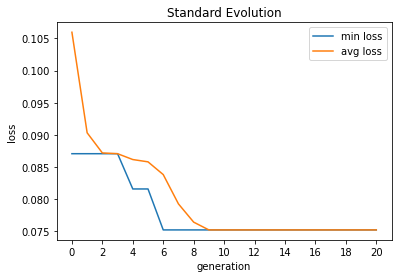

In [19]:
stdLogbook = stdResults.history

generations, minValues, avgValues = stdLogbook.select('gen', 'min', 'avg')

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=20))
ax.plot(generations, minValues, label='min loss')
ax.plot(generations, avgValues, label='avg loss')
ax.set_xlabel('generation')
ax.set_ylabel('loss')
ax.set_title('Standard Evolution')
ax.legend()

## **Differential Evolution.**

As an alternative to standard evolution, TheoTF also offers a differential evolution algorithm (as described in *Reiner and Storn, 1997*). Using differential evolution is not different than using standard evolution. Instead of using a `StandardEvoOpt`, you can use a `DifferentialEvoOpt`, contained in the `theotf.optimizers` module as well.

In [10]:
# Differential optimizer. Using default population size (10) and default number of generations (20)
diffEvoOpt = optimizers.DifferentialEvoOpt(refModel, paramsGrid)

In [11]:
beg = time()

diffResults = diffEvoOpt.fit(train=(x_train, y_train),
                            validation=(x_val, y_val),
                            tfLoss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            tfCallbacks=[earlyStoppingCBK])

duration = time() - beg

print(f'\nDifferential optimization took {duration} seconds.')

Evaluating generation 0...
Individual [56, 0, 0.3176647148576384, 167, 2, 0.3294329181463802] evaluated; fitness=(0.09711013734340668,)
Individual [86, 0, 0.38365704454182326, 201, 0, 0.4709488569823971] evaluated; fitness=(0.09333255141973495,)
Individual [128, 2, 0.33875364964431925, 41, 2, 0.42250580481434424] evaluated; fitness=(0.10015819221735,)
Individual [77, 2, 0.5078547483393789, 41, 2, 0.5964825136840166] evaluated; fitness=(0.16424542665481567,)
Individual [47, 2, 0.42518956908045613, 191, 1, 0.3276981327293301] evaluated; fitness=(0.13245545327663422,)
Individual [101, 0, 0.3849682762129825, 117, 0, 0.49890420017213877] evaluated; fitness=(0.08846678584814072,)
Individual [89, 1, 0.373558245302585, 246, 0, 0.3422718175690706] evaluated; fitness=(0.08448239415884018,)
Individual [67, 2, 0.4795451309784764, 71, 2, 0.5196151143216704] evaluated; fitness=(0.14426083862781525,)
Individual [112, 1, 0.5625616803660669, 84, 2, 0.4054571748772677] evaluated; fitness=(0.124636076390

In [12]:
print(diffResults.bestParams)
print(diffResults.bestLoss)

{'Dense1.units': 128, 'Dense1.activation': <function sigmoid at 0x7ff14771a160>, 'Dropout1.rate': 0.3290747457680359, 'Dense2.units': 256, 'Dense2.activation': <function relu at 0x7ff147716c10>, 'Dropout2.rate': 0.3207109141495316}
(0.07130669802427292,)


In [13]:
diffModel = diffResults.bestModel

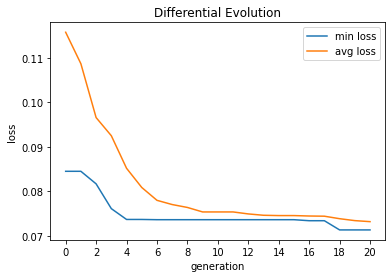

In [17]:
diffLogbook = diffResults.history

generations, minValues, avgValues = diffLogbook.select('gen', 'min', 'avg')

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=20))
ax.plot(generations, minValues, label='min loss')
ax.plot(generations, avgValues, label='avg loss')
ax.set_xlabel('generation')
ax.set_ylabel('loss')
ax.set_title('Differential Evolution')
ax.legend()